In [ ]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#Text cleaning
import re,string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))  # Sesuaikan dengan bahasa yang sesuai
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW , get_linear_schedule_with_warmup

from sklearn.metrics import classification_report , confusion_matrix

#Seed for reproducibility
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

import time

#set style for plots
sns.set_style('whitegrid')
sns.despine()
plt.style.use('seaborn-whitegrid')
plt.rc("figure",autolayout=True)
plt.rc('axes',labelweight='bold',labelsize='large',titleweight='bold',titlepad=10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-2-d0f9e0243457>:59: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.read_csv('/content/Bullying - Copy.csv')
df.head()

,Deskripsi_Kejadian,Jenis_Bullying
0,"dipukul, disundut dengan rokok, disundut pakai...",Fisik
1,"Ketika saya jajan, saya dibuat jatuh oleh pela...",Fisik
2,Ketika korban sedang mengikuti lomba kemerdeka...,Fisik
3,"Memberikan korban pukulan hingga menendang, se...",Fisik
4,2 pelaku memegangi kaki kucing. Kemudian pakai...,Seksual


In [ ]:
df.info

<bound method DataFrame.info of                                    Deskripsi_Kejadian  Jenis_Bullying
0   dipukul, disundut dengan rokok, disundut pakai...           Fisik
1   Ketika saya jajan, saya dibuat jatuh oleh pela...           Fisik
2   Ketika korban sedang mengikuti lomba kemerdeka...           Fisik
3   Memberikan korban pukulan hingga menendang, se...           Fisik
4   2 pelaku memegangi kaki kucing. Kemudian pakai...         Seksual
5   Dipukul, ditendang, karena korban mengaku masu...           Fisik
6   Korban diperkosa dan dipaksa berhubungan sesam...         Seksual
7   Terjadi di pondok pesantren. Pelaku mengarahka...           Fisik
8   rambutnya dijambak, disiram air, tubuhnya diin...           Fisik
9   Kemaluan korban dipegang-pegang. Korban disuru...         Seksual
10  Korban hendak pergi ke masjid sekolah untuk sa...           Fisik
11  Korban dikeroyok oleh 6 pelaku, hingga korban ...           Fisik
12  Pelaku memukul korban dan menendang berkali-ka...           Fisik
13  Korban dipukul dan kepalanya ditendang serta d...           Fisik
14  Korban didorong hingga terjatuh, diseret, dan ...           Fisik
15  Korban dibanting dan ditendang berkali kali di...           Fisik
16  Korban dipukul pada bagian kepala, wajah, mata...           Fisik
17  Saya dipasangkan helm oleh pelaku kemudian kep...           Fisik
18  Saya dituduh melakukan suap agar nilai saya se...          Psikis
19  Saya kerap dipanggil dengan nama orang tua say...          Psikis
20  Seorang anak sd ditertawakan oleh guru dan tem...          Psikis
21  Korban sering diejek anak yatim oleh temannya ...          Psikis
22  Korban dijambak, diludahi, disiram air, diseka...           Fisik
23       Sekolah memaksa siswinya menggunakan jilbab.  Bukan Bullying
24  korban diangkat beramai-ramai kemudian dibanti...           Fisik
25  Pelaku memukul dan menendang adik kelasnya yan...           Fisik
26  Korban dipaksa melakukan hubungan badan, jika ...         Seksual
27  Saat itu korban datang untuk meminta tanda tan...         Seksual
28  Saya dipaksa guru saya untuk membersihkan toil...  Bukan Bullying
29      Saya dimarahi guru saya karena bolos sekolah.  Bukan Bullying
30  Saya kena hukum berdiri ditiang bendera karena...  Bukan Bullying
31       Saya selalu beli siomay setiap jam istirahat  Bukan Bullying
32                  Saya mengerjakan pr kemarin malam  Bukan Bullying
33  Saya mendapatkan apresiasi karena menjuarai ol...  Bukan Bullying>

In [ ]:
df = df.rename(columns={'Deskripsi_Kejadian':'text','Jenis_Bullying':'sentiment'})

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df[~df.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       34 non-null     object
 1   sentiment  34 non-null     object
dtypes: object(2)
memory usage: 672.0+ bytes


In [ ]:
# Mencari nilai null
null_values = df[df.isnull().any(axis=1)]

# Mencari baris duplikat
duplicate_rows = df[df.duplicated()]

In [ ]:
df.sentiment.value_counts()

sentiment
Fisik             18
Bukan Bullying     7
Seksual            5
Psikis             4
Name: count, dtype: int64

In [ ]:
def conf_matrix(y,y_pred,title,labels):
    fig , ax = plt.subplots(figsize=(7.5,7.5))
    ax = sns.heatmap(confusion_matrix(y,y_pred),annot=True,cmap='Purples',fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title,fontsize=25)
    ax.xaxis.set_ticklabels(labels,fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test',fontsize=25)
    ax.set_xlabel('Predicted',fontsize=25)
    plt.show()

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE Text

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r',' ').replace('\n',' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+","",text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'',text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list = string.punctuation
    table = str.maketrans('','',banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text = ' '.join(word for word in text.split() if len(word)<14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t","can not",text)
    text = re.sub(r"n\'t"," not",text)
    text = re.sub(r"\'re"," are",text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text)) #remove hashtags symbol from words in the middle of the sentence
    return new_text2


#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent=[]
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+"," ",text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [ ]:
df['text'] = df['text'].astype(str)

texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

In [ ]:
df['text_clean'] = texts_new

In [ ]:
# Are there duplicate tweets after the cleaning?
print(df.shape)
print(df["text_clean"].duplicated().sum())
# There are around 3000 duplicated tweets, we will remove them.
df.drop_duplicates('text_clean',inplace=True)
df.shape

(34, 3)
0


(34, 3)

In [ ]:
# We removed the duplicated cleaned. How is the class balance after the cleaning?
df.sentiment.value_counts()

sentiment
Fisik             18
Bukan Bullying     7
Seksual            5
Psikis             4
Name: count, dtype: int64

In [ ]:
sentiments = ["Fisik","Psikis","Seksual","Bukan Bullying"]

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)


df['text_len'] = text_len

<ipython-input-18-15ef5767ec65>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.countplot(x='text_len',data=df[df['text_len']<10],palette='mako')


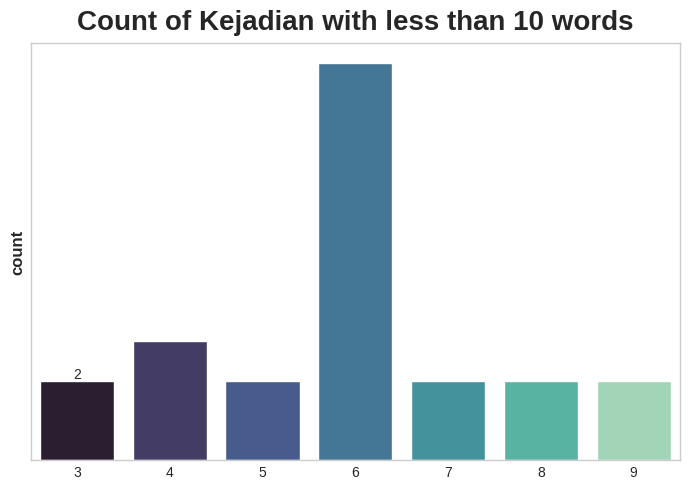

In [ ]:
plt.figure(figsize=(7,5))
ax= sns.countplot(x='text_len',data=df[df['text_len']<10],palette='mako')
plt.title('Count of Kejadian with less than 10 words',fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

<ipython-input-19-e221a0a1836a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len',data=df, palette='Blues_r')


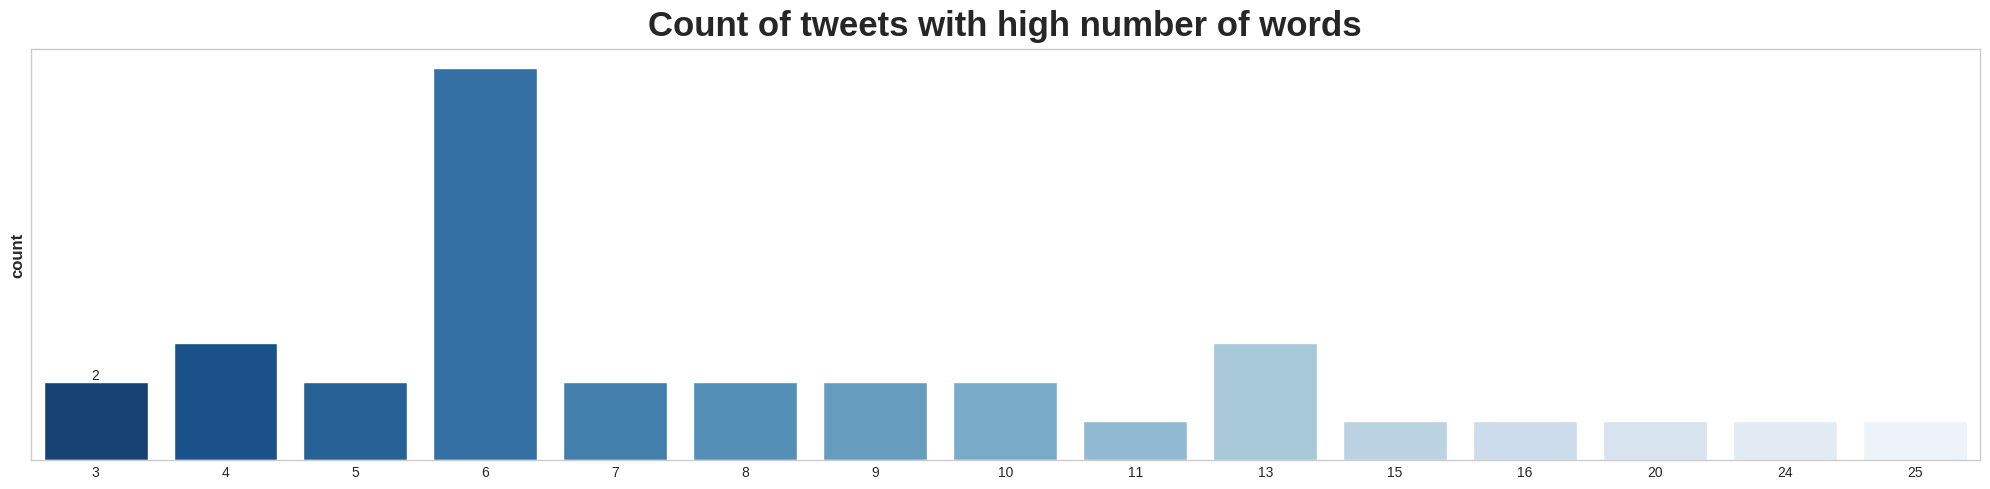

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len',data=df, palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
df = df[(df['text_len']>0)&(df['text_len']<100)]

In [ ]:
max_len = np.max(df['text_len'])
max_len

25

In [ ]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
10,Korban hendak pergi ke masjid sekolah untuk sa...,Fisik,korban pergi masjid sekolah salat zuhur tibati...,25
2,Ketika korban sedang mengikuti lomba kemerdeka...,Fisik,korban mengikuti lomba kemerdekaan ditarik kak...,24
7,Terjadi di pondok pesantren. Pelaku mengarahka...,Fisik,pondok pesantren pelaku mengarahkan setrika ua...,20
1,"Ketika saya jajan, saya dibuat jatuh oleh pela...",Fisik,jajan jatuh pelaku sengaja menjulurkan kakinya...,16
4,2 pelaku memegangi kaki kucing. Kemudian pakai...,Seksual,2 pelaku memegangi kaki kuce pakaian si anak d...,15
0,"dipukul, disundut dengan rokok, disundut pakai...",Fisik,dipukul disundut rokok disundut pakai korek ap...,13
27,Saat itu korban datang untuk meminta tanda tan...,Seksual,korban tanda tangan menyelesaikan skripsi pela...,13
22,"Korban dijambak, diludahi, disiram air, diseka...",Fisik,korban dijambak diludahi disiram air disekap d...,13
9,Kemaluan korban dipegang-pegang. Korban disuru...,Seksual,kemaluan korban korban disuruh buka celana nun...,11
3,"Memberikan korban pukulan hingga menendang, se...",Fisik,korban pukulan menendang sembari memaki korban...,10


In [ ]:
df['sentiment'] = df['sentiment'].replace({'Fisik':0,'Psikis':1,'Seksual':2,'Bukan Bullying':3})

In [ ]:
df.dropna(subset=['sentiment'], inplace=True)

In [ ]:
X = df['text_clean']
y = df['sentiment']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 14],
       [ 1,  3],
       [ 2,  4],
       [ 3,  6]])

In [ ]:
ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train],y_train)),columns=['text_clean','sentiment'])

In [ ]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 14],
       [ 1, 14],
       [ 2, 14],
       [ 3, 14]])

In [ ]:
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_valid_cv = clf.transform(X_valid)

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_valid_tf = tf_transformer.transform(X_valid_cv)

In [ ]:
nb_clf = MultinomialNB(alpha=0.5)
nb_clf.fit(X_train_tf,y_train)
nb_pred = nb_clf.predict(X_valid_tf)

In [ ]:
print(df['sentiment'].value_counts())


sentiment
0    18
3     7
2     5
1     4
Name: count, dtype: int64


In [ ]:
print('Classification Report for Naive Bayes:\n',classification_report(y_valid,nb_pred,target_names=sentiments))

Classification Report for Naive Bayes:
                 precision    recall  f1-score   support

         Fisik       1.00      1.00      1.00         4
        Psikis       1.00      1.00      1.00         1
       Seksual       1.00      1.00      1.00         1
Bukan Bullying       1.00      1.00      1.00         1

      accuracy                           1.00         7
     macro avg       1.00      1.00      1.00         7
  weighted avg       1.00      1.00      1.00         7



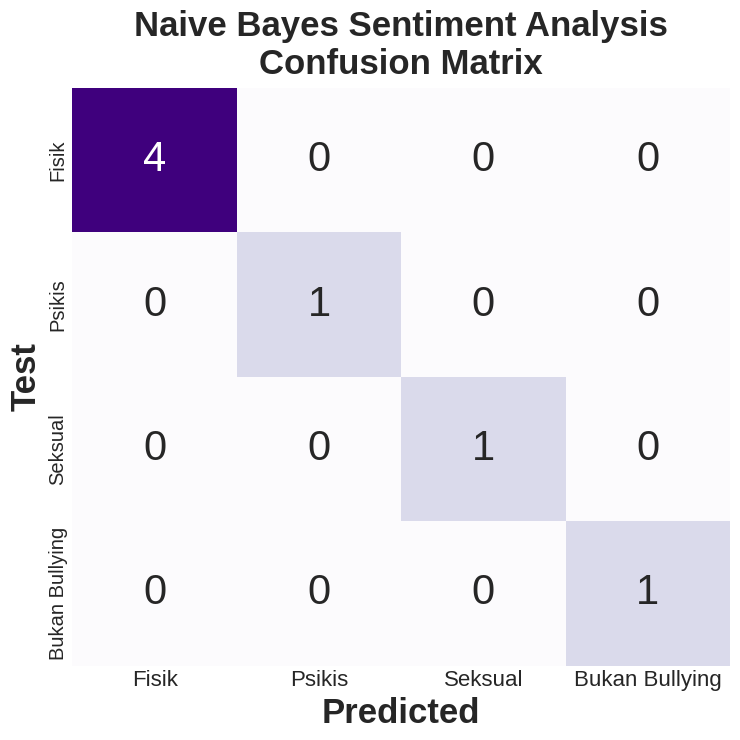

In [ ]:
conf_matrix(y_valid,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix',sentiments)

In [ ]:
def Tokenize(column,seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)

    ##Add padding to tokens
    features = np.zeros((len(text_int),seq_len),dtype=int)
    for i,review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[:seq_len]
        features[i,:]=np.array(new)

    return sorted_words,features

In [ ]:
vocabulary,tokenized_column = Tokenize(df['text_clean'],max_len)

In [ ]:
# We can check how each kejadian has been tokenized with an example:
print(df["text_clean"].iloc[10])
print(' ')
print('This sentence is transformed to the vector:\n')
print(tokenized_column[10])

korban pergi masjid sekolah salat zuhur tibatiba temannya menutupi wajah korban sajadah tangan korban diikat dipukul pelaku korban meningg akibat kelainan usu mendapati kekerasan fisik
 
This sentence is transformed to the vector:

[  1 112 113   6 114 115 116   8 117  13   1 118  30   1  16   3   2   1
 119 120 121 122 123 124 125]


In [ ]:
# Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.
keys = []
values = []
for key,value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

<ipython-input-39-d381cfed00a8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=keys, y=values, palette='mako')  # Gunakan x=keys dan y=values untuk menentukan data


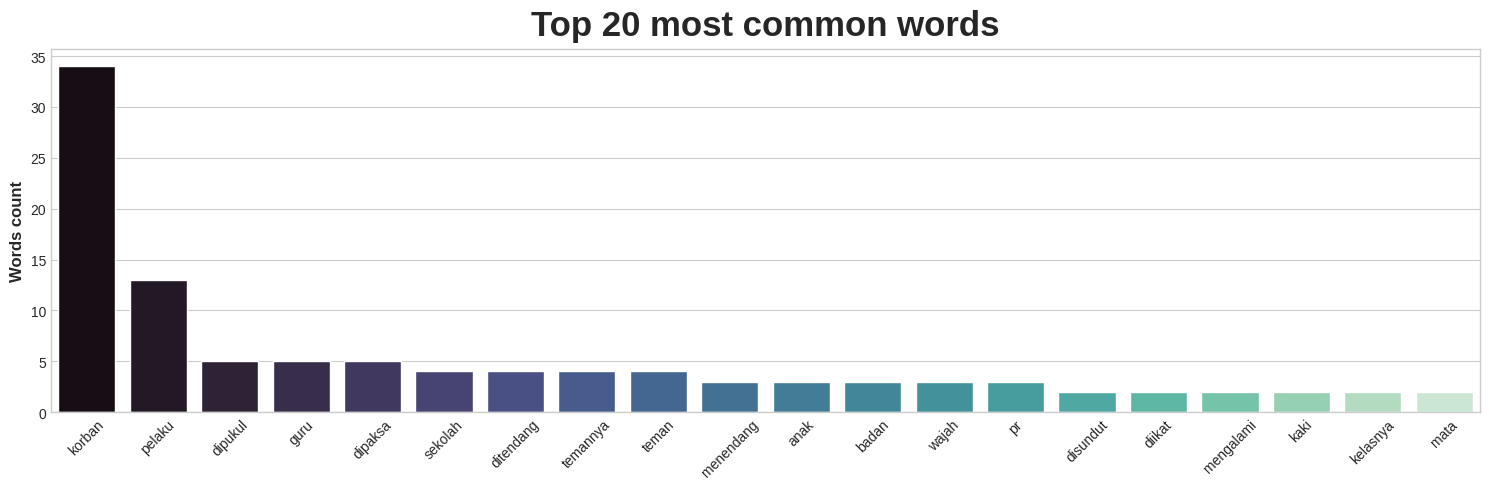

In [ ]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')  # Gunakan x=keys dan y=values untuk menentukan data
plt.title('Top 20 most common words', size=25)
plt.ylabel("Words count")
plt.xticks(rotation=45)  # Rotasi label sumbu x agar lebih mudah dibaca
plt.show()

In [ ]:
Word2vec_train_data = list(map(lambda x:x.split(),X_train))

In [ ]:
EMBEDDING_DIM = 200

In [ ]:
word2vec_model = Word2Vec(Word2vec_train_data,vector_size=EMBEDDING_DIM)

In [ ]:
print(f"Vocabulary size: {len(vocabulary) + 1}")
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Vocabulary size: 207


In [ ]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE,EMBEDDING_DIM))

#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)

for word,token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token]=word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (207, 200)


In [ ]:
X = tokenized_column
y = df['sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [ ]:
# We can check the balance of the target classes:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 14],
       [ 1,  3],
       [ 2,  4],
       [ 3,  6]])

In [ ]:
# And then apply random oversampling on the training set.
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [ ]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 14],
       [ 1, 14],
       [ 2, 14],
       [ 3, 14]])

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train_os),torch.from_numpy(y_train_os))
valid_data = TensorDataset(torch.from_numpy(X_valid),torch.from_numpy(y_valid))

BATCH_SIZE = 32

train_loader = DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.1 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BiLSTM_Sentiment_Classifier(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,num_classes,lstm_layers,bidirectional,batch_size,dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers = lstm_layers,
                           dropout=dropout,
                           bidirectional=bidirectional,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim*self.num_directions,num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,x,hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out ,hidden = self.lstm(embedded,hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out,hidden

    def init_hidden(self,batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0,c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(207, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [ ]:
EPOCHS = 20  # Ubah nilai EPOCHS menjadi yang diinginkan (misalnya, 20)

total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0  # Initialize best accuracy top 0

for e in range(EPOCHS):
    # Kode pelatihan dan validasi tetap sama seperti sebelumnya
    ...

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients

        output, h = model(inputs,h) #get output and hidden states from LSTM network

        loss = criterion(output, labels)
        loss.backward()

        running_loss += loss.item()

        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list

        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####

    with torch.no_grad():

        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase

    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 57.142857).  Saving model ...
	Train_loss : 0.0093 Val_loss : 1.0052
	Train_acc : 100.000% Val_acc : 57.143%
Epoch 2:Validation accuracy increased (57.142857 --> 57.142857).  Saving model ...
	Train_loss : 0.0088 Val_loss : 1.0104
	Train_acc : 100.000% Val_acc : 57.143%
Epoch 3:Validation accuracy increased (57.142857 --> 57.142857).  Saving model ...
	Train_loss : 0.0084 Val_loss : 1.0143
	Train_acc : 100.000% Val_acc : 57.143%
Epoch 4:Validation accuracy increased (57.142857 --> 57.142857).  Saving model ...
	Train_loss : 0.0078 Val_loss : 1.0158
	Train_acc : 100.000% Val_acc : 57.143%
Epoch 5:Validation accuracy increased (57.142857 --> 57.142857).  Saving model ...
	Train_loss : 0.0077 Val_loss : 1.0166
	Train_acc : 100.000% Val_acc : 57.143%
Epoch 6:Validation accuracy increased (57.142857 --> 57.142857).  Saving model ...
	Train_loss : 0.0072 Val_loss : 1.0161
	Train_acc : 100.000% Val_acc : 57.143%
Epoch 7:Validation accuracy i

In [ ]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [ ]:
y_pred_list = []
y_val_list = []
for inputs, labels in valid_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    val_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, val_h)
    y_pred_val = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_val.squeeze().tolist())
    y_val_list.extend(labels.squeeze().tolist())

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for Bi-LSTM :
                 precision    recall  f1-score   support

         Fisik       1.00      0.75      0.86         4
        Psikis       0.00      0.00      0.00         1
       Seksual       0.50      1.00      0.67         1
Bukan Bullying       0.50      1.00      0.67         1

      accuracy                           0.71         7
     macro avg       0.50      0.69      0.55         7
  weighted avg       0.71      0.71      0.68         7

 


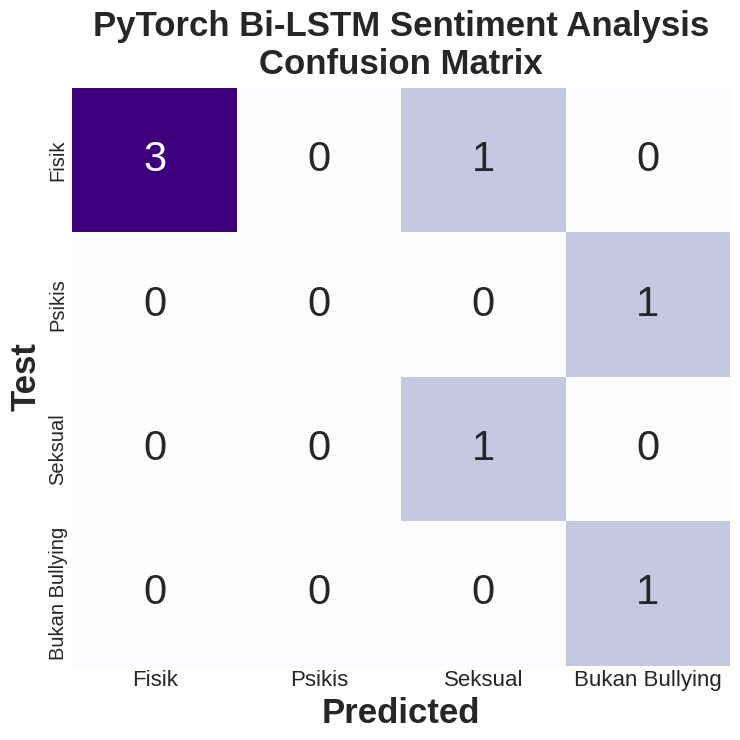

In [ ]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_val_list, y_pred_list, target_names=sentiments))
print(' ')
conf_matrix(y_val_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

In [ ]:
X = df['text_clean'].values
y = df['sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 14],
       [ 1, 14],
       [ 2, 14],
       [ 3, 14]])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def Bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
        )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids,attention_masks

In [ ]:
# Tokenize train Kejadian
encoded_texts = [tokenizer.encode(sent,add_special_tokens=True) for sent in X_train]

# Find the longest tokenized Kejadian
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len) # -> 126

# Let's keep MAX_LEN = 128
MAX_LEN = 128

Max length:  66


In [ ]:
train_inputs, train_masks = Bert_tokenizer(X_train_os)
val_inputs, val_masks = Bert_tokenizer(X_valid)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_labels = torch.tensor(y_train_os)
val_labels = torch.tensor(y_valid)

In [ ]:
batch_size = 32

# Create the DataLoader for our training set
train_dataset = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = torch.utils.data.DataLoader(train_dataset,sampler=train_sampler,batch_size=batch_size,num_workers=2)

# Create the DataLoader for our validation set
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset,sampler=val_sampler,batch_size=batch_size,num_workers=2)